<a href="https://colab.research.google.com/github/anmri/github-slideshow/blob/master/Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import numpy as np     
import math as math
import matplotlib.pyplot as plt

class FlowVoronoi:
    WORRY = 0    # pripada kot pi
    ANXIETY = 1    # kot 3*pi/4 ...
    AROUSAL = 2
    FLOW = 3
    CONTROL = 4
    RELAXATION = 5
    BOREDOM = 6
    APATHY = 7
    UNDECIDED = 8
    
    emotions = ['WORRY', 'ANXIETY', 'AROUSAL', 'FLOW', 'CONTROL', 'RELAXATION', 'BOREDOM', 'APATHY', 'UNDECIDED']
    
    # MIN_ZONE_RADIUS = 0.75
    cells = 9
    dSize = 1.0
    rCenter = 0.005
    # emoPhi1 = [math.pi, 3*math.pi/4, math.pi/2, math.pi/4, 0, -math.pi/4, -math.pi/2, -3*math.pi/4,0]
    emoPhi = [7*math.pi/8, 5*math.pi/8, 3*math.pi/8, math.pi/8, -math.pi/8, -3*math.pi/8, -5*math.pi/8, -7*math.pi/8, math.pi/8]
    
    # def __init__(self):
        # TODO
        
    def emotionName(self, em):
        return self.emotions[em]
        
    def radius (self, x, y):
        x = x - self.dSize/2
        y = y - self.dSize/2
        return math.sqrt(x*x+y*y)
    
    def angle (self, x, y):
        x = x - self.dSize/2
        y = y - self.dSize/2
        return math.atan2(y,x)
    
    def emotionFromAngle(self, x, y):         # x...skill,y...challenge
        if self.radius(x,y) < self.rCenter:
            return self.UNDECIDED  # 8
        
        angle = self.angle(x,y)
        
        for i in range(self.cells-1):     # cells = 9
            if angle < self.emoPhi[i] and angle > self.emoPhi[i+1]:
                return i+1
        
        return 0
                    
class Individual:
    def __init__(self, numberOfTasks, l, p, r):
        self.passion = p
        self.perserverance = r
        self.learning = l
        self.overallSkill = [] #elements are skill levels of task
        self.overallChallenge = [] #elements are challenge levels of tasks
        self.numberOfTasks = numberOfTasks
        self.learningPeriod = 1000 #number of times we learn
        
        #parameters we can play with to get different output graphs
        self.coefGSkill = -1
        self.coefGChallenge = 1
        self.coefGExpected = -1
        self.coefGOffset = 0.5
        self.coefFSkill = -1
        self.coefFExpected = -1
        self.coefFOffset = 0.5
        
        for i in range(numberOfTasks):
            self.overallSkill.append(np.random.uniform(0,1))
            self.overallChallenge.append(np.random.uniform(0,1))
        
    def learn(self, index):
        
        pf = self.probabilityFailure(index)
        pg = self.probabilityGiveUp(index)
        ps = (1-pg)*(1-pf) 
        r = np.random.uniform(0,1)
        if r < pf:
            self.failure(index)
            # print("Fail")
        elif r < pg+pf:
            self.giveup(index)
            # print("giveUp")
        else:
            self.success(index)
            # print("Success")
        
        #we return overall challenge and skills after we have "learned"

        x = []
        y = []
        for i in range(self.numberOfTasks):
            x.append(self.overallChallenge[i])
            y.append(self.overallSkill[i])
        return y, x
        
        
    def probabilityFailure(self, index):
        p =  1/(1+math.exp((-self.coefFSkill * self.overallSkill[index]-self.coefFExpected * self.expectedAbility(index)+self.coefFOffset)/(1.01-self.perserverance)))
        # print(p)
        return p

        # java: double res = 1/(1+Math.exp((
				#-Individual.coefFSkill     * aSkill
				#-Individual.coefFExpected  * this.expectedAbility
				#+Individual.coefFOffset)/(1-this.perserverance)));
    
    def probabilityGiveUp(self, index):
        p = 1/(1+math.exp((-self.coefGSkill * self.overallSkill[index] +self.coefGChallenge * self.overallChallenge[index] -self.coefGExpected * self.expectedAbility(index)+self.coefGOffset)/(1.01-self.perserverance)))
        # print(p)
        return p
    
    def expectedAbility(self, index):
        #average of all skills of tasks except of task at index index
        res = 0
        for i in range(self.numberOfTasks):
            if(i == index):
                continue
            res += self.overallSkill[i]
        res = res/self.numberOfTasks   
        return res
    
    #with next functions we change <challenge and skill level of the task in 
    #in case of failure, success and giving up
    
    def failure(self, index):
        self.overallChallenge[index] -= (1-self.perserverance)*self.overallChallenge[index]
        self.overallSkill[index] += (self.learning*self.overallChallenge[index]*(1-self.overallSkill[index]))*self.overallSkill[index]*np.random.uniform(0,1)

    def success(self, index):
        self.overallChallenge[index] += self.passion*(1-self.overallChallenge[index])*self.overallChallenge[index]
        self.overallSkill[index] += (self.learning*self.overallChallenge[index]*(1-self.overallSkill[index]))*self.overallSkill[index]
    
    def giveup(self, index):
        self.overallChallenge[index] -= (1-self.perserverance)*self.overallChallenge[index]
        self.overallSkill[index] += (self.learning*self.overallChallenge[index]*(1-self.overallSkill[index]))*self.overallSkill[index]*np.random.uniform(0,1)

    def printOverallSkill(self):
        for i in range(self.numberOfTasks):
            print(self.overallSkill[i])
            
    def averageSkill(self):
        res = 0
        for i in range(self.numberOfTasks):
            res += self.overallSkill[i]
        res = res/self.numberOfTasks   
        return res
    
    def averageChallenge(self):
        res = 0
        for i in range(self.numberOfTasks):
            res += self.overallChallenge[i]
        res = res/self.numberOfTasks   
        return res

    def average(self, polje):
      res = 0
      for i in range(len(polje)):
        res += polje[i]
      res = res/len(polje)   
      return res
    
    
class FlowSimulation:
    def __init__(self, individual):
        self.individual = individual
        self.n = individual.numberOfTasks
        
    def chart(self, x, y):
        for i in range(self.n):
            z=[]
            w=[]
            for j in range(self.individual.learningPeriod):
                z.append(x[j][i])
                w.append(y[j][i])
            plt.plot(w,z,linewidth=0.8) #za vsak i - število taskov, narišemo "črto"
            
            
            plt.rcParams["figure.figsize"] = (7,5)
            plt.plot([w[0]], [z[0]], 'ro',markersize=4)
        
            plt.plot([w[self.individual.learningPeriod -1]], [z[self.individual.learningPeriod -1]], 'g^', markersize=4)
        
    def flow(self):
        x1 =[]
        y1 =[]
        
        for z in range(self.individual.learningPeriod): #nafilaš x1 in y1 z ničlami
            x1.append(0)
            y1.append(0)

        for i in range(self.individual.learningPeriod):
            r = np.random.randint(0, self.n)
            x1[i] , y1[i] =self.individual.learn(r) #learn vrača 2 polja - polje skillov in challengeov
        
        return x1[self.individual.learningPeriod-1], y1[self.individual.learningPeriod-1]

        #self.chart(x1 , y1) #x1 in y1 sta polji skillov in chalengeov potem ko smo se že naučili
            
        #plt.xlabel('Skill')
        #plt.ylabel('Challenge')
        #plt.show()

In [103]:
count = [0,0,0,0,0,0,0,0,0]
fv = FlowVoronoi()

for i in range(100):     
    print("NOVI POSAMEZNIK")
    person = Individual(50, 1.0, 0.4, 0.1)
    x = FlowSimulation(person)
    a,b = x.flow()  #ch, sk
    a1 = person.average(a)
    b1 = person.average(b)
    print(a1,b1)
    count[fv.emotionFromAngle(a1,b1)] += 1
    
print(fv.emotions)
print(count)

NOVI POSAMEZNIK
0.7867929899422849 0.15521398586708413
NOVI POSAMEZNIK
0.798376308902251 0.18891695749763537
NOVI POSAMEZNIK
0.7699371590469162 0.2253677303001249
NOVI POSAMEZNIK
0.7631106188190128 0.1520709528373857
NOVI POSAMEZNIK
0.719268265297632 0.07044970064026958
NOVI POSAMEZNIK
0.7360988302890956 0.2155804915580462
NOVI POSAMEZNIK
0.722791985766261 0.2224060624539816
NOVI POSAMEZNIK
0.7877853435896557 0.25205855824882634
NOVI POSAMEZNIK
0.8223024986808802 0.19507613448903605
NOVI POSAMEZNIK
0.7512780874196286 0.14210897799857397
NOVI POSAMEZNIK
0.7286334248172964 0.1639799798299668
NOVI POSAMEZNIK
0.7579903827702527 0.2150889404351687
NOVI POSAMEZNIK
0.6681329150495604 0.16904041989944826
NOVI POSAMEZNIK
0.7546567685620673 0.2158101202523176
NOVI POSAMEZNIK
0.7401917484203103 0.17109469767769725
NOVI POSAMEZNIK
0.7446018489582932 0.17182284460790204
NOVI POSAMEZNIK
0.751438010553622 0.14754404286757244
NOVI POSAMEZNIK
0.7225265657347048 0.15519491654811432
NOVI POSAMEZNIK
0.740

In [104]:
l = 1.0
for p in np.arange(0.0,1.1,0.1):
  for r in np.arange(0.0,1.1,0.1):
    p1 = round(p,1)
    r1 = round(r,1)
    print([l,p1,r1])
    count = [0,0,0,0,0,0,0,0,0]
    for i in range(10):
      person = Individual(100, l, p1, r1)
      x = FlowSimulation(person)
      a,b = x.flow()
      a1 = person.average(a)
      b1 = person.average(b)
      count[fv.emotionFromAngle(a1,b1)] += 1
    #print(fv.emotions)
    print(count)

[1.0, 0.0, 0.0]
[0, 0, 0, 0, 0, 0, 10, 0, 0]
[1.0, 0.0, 0.1]
[0, 0, 0, 0, 0, 7, 3, 0, 0]
[1.0, 0.0, 0.2]
[0, 0, 0, 0, 0, 10, 0, 0, 0]
[1.0, 0.0, 0.3]
[0, 0, 0, 0, 0, 10, 0, 0, 0]
[1.0, 0.0, 0.4]
[0, 0, 0, 0, 3, 7, 0, 0, 0]
[1.0, 0.0, 0.5]
[0, 0, 0, 0, 10, 0, 0, 0, 0]
[1.0, 0.0, 0.6]
[0, 0, 0, 0, 10, 0, 0, 0, 0]
[1.0, 0.0, 0.7]
[0, 0, 0, 0, 10, 0, 0, 0, 0]
[1.0, 0.0, 0.8]
[0, 0, 0, 0, 10, 0, 0, 0, 0]
[1.0, 0.0, 0.9]
[0, 0, 0, 0, 10, 0, 0, 0, 0]
[1.0, 0.0, 1.0]
[0, 0, 0, 0, 10, 0, 0, 0, 0]
[1.0, 0.1, 0.0]
[0, 0, 0, 0, 0, 5, 5, 0, 0]
[1.0, 0.1, 0.1]
[0, 0, 0, 0, 0, 9, 1, 0, 0]
[1.0, 0.1, 0.2]
[0, 0, 0, 0, 0, 10, 0, 0, 0]
[1.0, 0.1, 0.3]
[0, 0, 0, 0, 6, 4, 0, 0, 0]
[1.0, 0.1, 0.4]
[0, 0, 0, 0, 10, 0, 0, 0, 0]
[1.0, 0.1, 0.5]
[0, 0, 0, 0, 10, 0, 0, 0, 0]
[1.0, 0.1, 0.6]
[0, 0, 0, 1, 9, 0, 0, 0, 0]
[1.0, 0.1, 0.7]
[0, 0, 0, 3, 7, 0, 0, 0, 0]
[1.0, 0.1, 0.8]
[0, 0, 0, 9, 1, 0, 0, 0, 0]
[1.0, 0.1, 0.9]
[0, 0, 0, 2, 8, 0, 0, 0, 0]
[1.0, 0.1, 1.0]
[0, 0, 0, 2, 8, 0, 0, 0, 0]
[1.0, 0.2, 0.0]
[0, 

In [105]:
count = [0,0,0,0,0,0,0,0,0]
anim = []
matrika = np.zeros((11,11), dtype='i,i')

l = 0.0
p = 0.0
r = 0.0

for i1 in range(11):
  for i2 in range(11):
    for i3 in range(11):
      for ind in range(5):
        person = Individual(50, l, p, r)
        x = FlowSimulation(person)
        a, b = x.flow() 
        a1 = person.average(a)
        b1 = person.average(b)
        count[fv.emotionFromAngle(a1,b1)] += 1
      em = count.index(max(count))
      odstotek = float(max(count)/sum(count))*100
      matrika[10-i3][i2] = (em,odstotek)
      count = [0,0,0,0,0,0,0,0,0]
      r += 0.1
    r = 0.0
    p += 0.1
  anim.append(matrika)
  matrika = np.zeros((11,11), dtype='i,i')
  p = 0.0
  l += 0.1
  
print(anim)
print(len(anim))


[array([[(4,  60), (2, 100), (2, 100), (2, 100), (2, 100), (2, 100),
        (2, 100), (2, 100), (2, 100), (2, 100), (2, 100)],
       [(3,  40), (2, 100), (2, 100), (2, 100), (2, 100), (2, 100),
        (2, 100), (2, 100), (2, 100), (2, 100), (2, 100)],
       [(2,  40), (2, 100), (2, 100), (2, 100), (2, 100), (2, 100),
        (2, 100), (2, 100), (2, 100), (2, 100), (2, 100)],
       [(6,  60), (2, 100), (2, 100), (2, 100), (2, 100), (2, 100),
        (2, 100), (2, 100), (2, 100), (2, 100), (2, 100)],
       [(6,  60), (2, 100), (2, 100), (2, 100), (2, 100), (2, 100),
        (2, 100), (2, 100), (2, 100), (2, 100), (2, 100)],
       [(6, 100), (6,  60), (2, 100), (2, 100), (2, 100), (2, 100),
        (2, 100), (2, 100), (2, 100), (2, 100), (2, 100)],
       [(6, 100), (6, 100), (6,  80), (1,  20), (2,  60), (2, 100),
        (2, 100), (2, 100), (2, 100), (2, 100), (2, 100)],
       [(6, 100), (6, 100), (6, 100), (6, 100), (6, 100), (6,  80),
        (3,  40), (7,  40), (2,  40), (2, 

ANIMACIJA


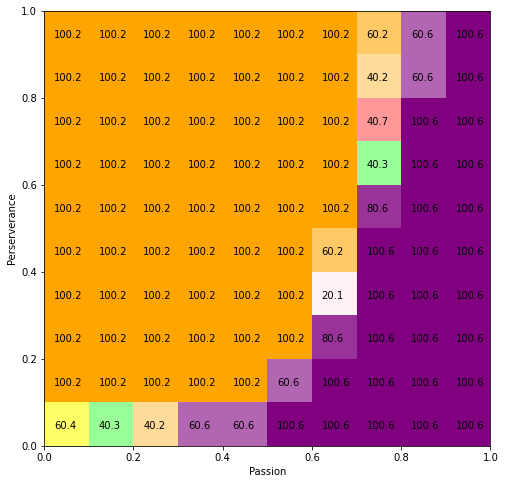

In [116]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

def graf(matrika):
    
  #barve za posamezna custva
  barve = {0: "white",1: "pink", 2: "orange",
            3: "lime", 4: "yellow",5: "blue",6: "purple",
            7: "red",8: "black"
  }

  fig, ax = plt.subplots(figsize=(8,8))

  for i in range(10):
      for j in range(10):
          #ustavri kvadratek
          rect = mpatches.Rectangle([i/10, j/10], 0.1, 0.1, ec="none", color = barve[matrika[i][j][0]], alpha =matrika[i][j][1]/100)
          ax.add_patch(rect)
          ax.text(i/10 +0.022, j/10 +0.039, str(matrika[i][j][1])+"."+str(matrika[i][j][0]))
  
  
  ax.set_xlabel('Passion')
  ax.set_ylabel('Perserverance')
  plt.show()
  
graf(anim[0])